In [1]:
import numpy as np
from numpy.fft import fft2, fft, ifft, ifft2

# mistakes: 
# giving fft input 2d array
# shapes
# variables easily get reassigned

In [2]:
N = 10
x = np.random.random(N).reshape((N//2, 2))
x

array([[0.59833082, 0.84848926],
       [0.73485443, 0.06342831],
       [0.78443021, 0.90811686],
       [0.29426007, 0.28647736],
       [0.29185817, 0.1859752 ]])

### axis enumeration:
axis=0   is up/down, ei. change of rows

axis=1   is left/right, ei. change of cols

In [3]:
res2 = fft2(x)
print(res2)


[[ 4.99622070e+00+0.j          4.11246709e-01+0.j        ]
 [ 2.03586169e-03-0.95827078j  8.38115226e-02-0.46058775j]
 [ 1.11690401e+00+0.86903839j -9.14830981e-01-0.45745271j]
 [ 1.11690401e+00-0.86903839j -9.14830981e-01+0.45745271j]
 [ 2.03586169e-03+0.95827078j  8.38115226e-02+0.46058775j]]


fft2 can be calculated by

first applying fft on each matrix row

then applying fft on that

In [4]:
# slower onEachRow = np.apply_along_axis(func1d=myfunc, axis=1, arr=x)
onEachRow = fft(x, axis=1)
#print(onEachRow)

# slower onEachCol = np.apply_along_axis(func1d=myfunc, axis=0, arr=onEachRow)
# np.apply_along_axis is slower because it uses python loops under the hood
onEachCol = fft(onEachRow, axis=0)
print(onEachCol)
print("good results? ", np.allclose(onEachCol, res2))

[[ 4.99622070e+00+0.j          4.11246709e-01+0.j        ]
 [ 2.03586169e-03-0.95827078j  8.38115226e-02-0.46058775j]
 [ 1.11690401e+00+0.86903839j -9.14830981e-01-0.45745271j]
 [ 1.11690401e+00-0.86903839j -9.14830981e-01+0.45745271j]
 [ 2.03586169e-03+0.95827078j  8.38115226e-02+0.46058775j]]
good results?  True


In [5]:
def myfft2(x):
    ''' Computes 2d fft using numpys fft '''
    onEachRow = fft(x, axis=1)
    return fft(onEachRow, axis=0)


In [6]:
t = np.arange(1000).reshape(10,100)
#%timeit f2 = fft2(t)
print('myfft2 is faster than fft2, but only at sub 10k lengths')
#%timeit f1 = myfft2(t)
print(np.allclose(myfft2(t), fft2(t)))

myfft2 is faster than fft2, but only at sub 10k lengths
True


In [7]:
def myfft_bad(x):
    #x = x.astype(float)
    N = x.shape[0]
    n = np.arange(N).reshape((N,1))
    k = n.reshape((1,N))
    # k and n make an N x N matrix of 
    # complex coefficients that get multiplied with x
    Mat = np.exp(np.pi * k * n/ N * -2j)
    return np.dot(Mat, x)

In [8]:
t=np.arange(4000)

v1 = myfft_bad(t)
v2 = fft(t)
print("they're insignificantly different")#,v1-v2)
np.allclose(v1,v2)

they're insignificantly different


True

In [9]:
print('at len(t)=3000 myff_bad takes 614ms, and at 4k it takes 1.1s')
print('while np.fft only takes 63µs')
#%timeit myfft_bad(t)
#%timeit fft(t)
print('myfft_bad is a lot slower than np.fft')
print('myfft_bad has O(N^2) numerical operations while np.fft has O(NlogN)')

at len(t)=3000 myff_bad takes 614ms, and at 4k it takes 1.1s
while np.fft only takes 63µs
myfft_bad is a lot slower than np.fft
myfft_bad has O(N^2) numerical operations while np.fft has O(NlogN)


In [10]:
#testing types
test = np.array([1,2,3])
test2 = test.astype(float)
print(test.dtype)
print(test2.dtype)

a = test.reshape(3,1)
print(a.shape)
a = test.reshape((3,1))
print(a.shape)

arr = np.arange(10)
print(arr.shape)
arr = np.arange(10).reshape(10,1)
print(arr.shape)

n = np.arange(10)
k = n.reshape((10, 1))
#print(n*k)
n = np.arange(10).reshape((10,1))
k = n.T
#print(n*k)
#print(n*n.T)

int32
float64
(3, 1)
(3, 1)
(10,)
(10, 1)


In [11]:
def myfft_better(x):
    ''' Cooley Tukey FFT, only works for lenghts that are power of 2 '''
    #x = x.astype(float)
    N = x.shape[0]
    
    if N % 2 != 0:
        raise Exception("Error, len(x) has to be power of 2")
    if N <= 8: # at some point it's better to fall back to the basic algorithm
        return myfft_bad(x)
    even = myfft_better(x[::2])
    odd = myfft_better(x[1::2])
    multiplier = np.exp( np.pi * np.arange(N) / N * -2j)
    return np.concatenate([even + multiplier[:N//2] * odd, 
        even + multiplier[N//2:] * odd])


In [12]:
t=np.arange(4096)

v1 = myfft_better(t)
v2 = fft(t)
#print("they're insignificantly differenc",v1-v2)
np.allclose(v1,v2)

True

In [13]:
#%timeit myfft_bad(t)
#%timeit myfft_better(t)
#%timeit fft(t)
print("myfft is still slower, but orders of magnitute faster than the other implementation")
print("len(t)=4096")
print("N=64 -> 17ms, N=32 -> 10ms, N=16 -> 9.5ms, N=8 -> 12.2ms")

myfft is still slower, but orders of magnitute faster than the other implementation
len(t)=4096
N=64 -> 17ms, N=32 -> 10ms, N=16 -> 9.5ms, N=8 -> 12.2ms


In [14]:
def my2dfft(x):
    onEachRow = np.apply_along_axis(myfft_better, 1, x)
    return np.apply_along_axis(myfft_better, 0, onEachRow)

In [15]:
t=np.random.rand(4096).reshape(512,8)

v1 = fft2(t)
v2 = my2dfft(t)
#print("they're insignificantly differenc",v1-v2)
np.allclose(v1,v2)

True

In [16]:
s = 256
t=np.arange(s*s).reshape(s,s)
#%timeit myfft2(t)
#%timeit my2dfft(t)
#%timeit fft2(t)

print('a lot slower than the fortrans fft2 implementation, but useable')
print('N=512x512 -> my2dfft 1s')

a lot slower than the fortrans fft2 implementation, but useable
N=512x512 -> my2dfft 1s


In [17]:
print('''Problem with the last implementation of fft is that on each node in the
recursive tree the same vector is constructed and multiplied with given input,
it would be a lot faster if it could be vectorized. And it can be!''')
def myfft_best(x):
    ''' vectorized Cooley Tukey, not recursive'''
    N = x.shape[0]
    #print(N)
    # hacky way of checking if a number is power of two
    # faster than log checking and not error prone
    if not ( ((N & (N - 1)) == 0) and N > 0 ):
        raise Exception("Error, len(x) has to be power of 2")
    
    # chungs of input onto which to apply the same multiplication
    sliceSize = min(N, 64)
    
    #One shape dimension can be -1. In this case, 
    #the value is inferred from the length of the array and remaining dimensions.
    xslices = x.reshape(sliceSize, -1)
    
    # applying calculation of myfft_bad on all slices
    n = np.arange(sliceSize)
    # in numpy None at index creates an axis with length 1.
    k = n[:, np.newaxis]
    factors = np.exp(np.pi * k * n/sliceSize * -2j)
    X = np.dot(factors, xslices)
    #print(X.shape[0])

    while N > X.shape[0]:
        #analogous to even/odd in myfft_better
        firstHalf = X[:, :X.shape[1]//2]
        secondHalf = X[:,  X.shape[1]//2:]
        Nvec = np.arange(X.shape[0])
        factor = np.exp(np.pi * Nvec / X.shape[0] * -1j)[:, np.newaxis]
        X = np.vstack([
            firstHalf + factor * secondHalf,
            firstHalf - factor * secondHalf
        ])
        #print('N',N)
        #print('X.shape[0]',X.shape[0])
    
    # reshape it to be same as input vector
    return X.reshape(N)

Problem with the last implementation of fft is that on each node in the
recursive tree the same vector is constructed and multiplied with given input,
it would be a lot faster if it could be vectorized. And it can be!


In [18]:
t=np.random.rand(128)
np.allclose(v1,v2)
v1 = fft(t)
v2 = myfft_best(t)
#print(v1)
#print(v2)


In [19]:
def my2dfft_better(x):
    onEachRow = np.apply_along_axis(myfft_best, 1, x)
    return np.apply_along_axis(myfft_best, 0, onEachRow)

In [20]:
s = 128
t=(np.random.randn(s*s) *255).reshape(s,s)

v1 = fft2(t)
v2 = my2dfft_better(t)
print(np.allclose(v1,v2))
print(v1.shape, v2.shape)
print('v1',v1[0:10,0])
print('v2',v2[0:10,0])


True
(128, 128) (128, 128)
v1 [  9091.27224661    +0.j          13143.67470655-49489.93058126j
  45624.12299869+17929.84267945j  -5070.04101297 +9760.41079379j
  -6822.58325021 -8761.46271577j  20091.18490487 +1643.43929943j
 -16235.6572277 +23362.59961653j  -5459.40994462 +4718.10008071j
  10809.4524607 -17585.29238129j  27489.5712815 +19644.56543204j]
v2 [  9091.27224661    +0.j          13143.67470655-49489.93058126j
  45624.12299869+17929.84267945j  -5070.04101297 +9760.41079379j
  -6822.58325021 -8761.46271577j  20091.18490487 +1643.43929943j
 -16235.6572277 +23362.59961653j  -5459.40994462 +4718.10008071j
  10809.4524607 -17585.29238129j  27489.5712815 +19644.56543204j]


In [21]:
print('''my2dfft_better is much faster than earlier implementation,
numpys fft2 is still better of course.''')
s = 512
t=np.arange(s*s).reshape(s,s)
# %timeit my2dfft_better(t)
# %timeit my2dfft(t)
# %timeit fft2(t)

print('''306 ms ± 3.74 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
1.38 s ± 12 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
11.6 ms ± 208 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)''')

my2dfft_better is much faster than earlier implementation,
numpys fft2 is still better of course.
306 ms ± 3.74 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
1.38 s ± 12 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
11.6 ms ± 208 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [22]:
# https://www.dsprelated.com/showarticle/800.php
def myifft(x):
    #method#3, for some reason it doesn't work
#     real = x.real
#     x.real = x.imag
#     x.imag = real
#     y = myfft_better(x)
#     real = y.real
#     y.real = y.imag
#     y.imag = real
#     return y / y.shape[0]
    # method#4, works well
    x.imag *= -1
    y = myfft_better(x)
    y.imag *= -1
    return y / y.shape[0]

In [23]:
x = np.arange(16)
f = fft(x)
print(np.allclose(ifft(f), myifft(f)))
print(ifft(f))
print(myifft(f))

True
[ 0.+0.00000000e+00j 15.+1.13242749e-14j 14.+9.42545333e-15j
 13.+1.03250741e-14j 12.+2.22044605e-16j 11.+3.33066907e-15j
 10.+3.00904454e-15j  9.+3.88578059e-15j  8.+0.00000000e+00j
  7.-4.66293670e-15j  6.-3.00904454e-15j  5.-4.32986980e-15j
  4.-2.22044605e-16j  3.-9.99200722e-15j  2.-9.42545333e-15j
  1.-9.88098492e-15j]
[ 0.+6.66133815e-16j 15.+7.94738930e-15j 14.+3.43999064e-15j
 13.+4.36876431e-15j 12.-2.26621556e-15j 11.-1.02576502e-16j
 10.+1.86519211e-15j  9.-1.44558843e-15j  8.-7.11903325e-16j
  7.-3.37688556e-15j  6.-1.00090146e-15j  5.+8.16050634e-16j
  4.+1.82212635e-15j  3.-6.09778084e-15j  2.-7.01659209e-15j
  1.+1.09889094e-14j]


In [24]:
# inverse calculations from fft2
def myifft2(x):
    onEachRow = np.apply_along_axis(myifft, 1, x)
    onEachCol =  np.apply_along_axis(myifft, 0, onEachRow)
    return onEachCol #.real

In [25]:
x = np.random.randn(16).reshape(4,4)
f = fft2(x)
print(np.allclose(ifft2(f), myifft2(f)))
print(ifft2(f))
print(myifft2(f))

True
[[-0.44066058+0.j -0.89314423+0.j  1.34624613+0.j  0.55513915+0.j]
 [-0.86377484+0.j  0.1458925 +0.j -0.57062712+0.j -0.39865752+0.j]
 [ 0.79668069+0.j  1.23398081+0.j -2.14596598-0.j -1.00460739+0.j]
 [-0.46287835+0.j -1.77326579+0.j  0.22502273+0.j  0.22424458+0.j]]
[[-0.44066058+0.00000000e+00j -0.89314423+1.92719248e-16j
   1.34624613-3.07550896e-16j  0.55513915-1.64844036e-16j]
 [-0.86377484+7.60648416e-17j  0.1458925 -1.21810891e-16j
  -0.57062712+1.92823247e-16j -0.39865752+1.32391800e-17j]
 [ 0.79668069-2.54564625e-16j  1.23398081-6.32385746e-16j
  -2.14596598+9.25084411e-16j -1.00460739+4.87101314e-16j]
 [-0.46287835+8.09075443e-17j -1.77326579+6.90810021e-16j
   0.22502273-4.73950526e-16j  0.22424458-3.78214716e-16j]]


The formula of a Gaussian function in one dimension is
$$G(x) = \frac{1}{\sqrt{2\pi \sigma^2}} e^{-\frac{x^2}{2 \sigma^2}}$$
In two dimensions, it is the product of two such Gaussian functions, one in each dimension:
$$G(x,y) = \frac{1}{{2\pi \sigma^2}} e^{- \frac{x^2 + y^2}{2 \sigma^2}}$$

In [26]:
# program implementation
import numpy as np
from numpy.fft import fft2, ifft2, fftshift, ifftshift
from scipy import ndimage
import math
import matplotlib.pyplot as plt

def getGaussMatrix(numRows, numCols, sigma, saveLowFreq):
    centerI = numRows//2 + 1 if numRows % 2 == 1 else numRows//2
    centerJ = numCols//2 + 1 if numCols % 2 == 1 else numCols//2

    def gaussian(i,j):
        coefficient = math.exp(-1.0 * ((i - centerI)**2 + (j - centerJ)**2) / (2 * sigma**2))
        return coefficient if saveLowFreq else 1 - coefficient
    
    G = np.array([[gaussian(i,j) for j in range(numCols)] for i in range(numRows)])
    #showImg(G)
    return G
 
def applyFilterOnDFT(imageMatrix, filterMatrix, useNpFunc):
    '''converts to dft, applies filterMatrix, then inverts dft'''
    #shiftedDFT = v1 = fftshift(fft2(imageMatrix))
    #v2 = fftshift(my2dfft_better(imageMatrix))
    #print('fft.allclose:',np.allclose(v1,v2))
    #print("shapes:", v1.shape, v2.shape)
    shiftedDFT = fftshift(fft2(imageMatrix)) if useNpFunc else \
       fftshift(my2dfft_better(imageMatrix))

    filteredDFT = shiftedDFT * filterMatrix
#     print("real:")
#     showImg(filteredDFT.real)
#     print("complex:")
#     showImg(filteredDFT.imag)

    #plt.imshow(filteredDFT.real, cmap='gray')
    #plt.show()
    
#     res = v1 =  ifft2(ifftshift(filteredDFT))
#     v2 = myifft2(ifftshift(filteredDFT))
#     print('ifft.allclose:',np.allclose(v1,v2))

    res = ifft2(ifftshift(filteredDFT)) if useNpFunc else \
       myifft2(ifftshift(filteredDFT))

    return res

def removeFreq(image, sigma, useNumpyDFT, highFreq=True):
    ''' if highFreq=True - filters out high freqs and passes low freqs 
    if highFreq=False - filters out low freqs and passes highFreqs'''
    (h,w) = image.shape
    G = getGaussMatrix(h, w, sigma, highFreq)
    return applyFilterOnDFT(image, G, useNumpyDFT)

def hybridImage(highFreqImg, lowFreqImg, sigmaHigh, sigmaLow, highOverLow=1.0, useNumpyDFT=True):
    '''combines high freq of one image with low freq of other image'''
    highFreq = removeFreq(highFreqImg, sigmaHigh, useNumpyDFT, highFreq=False)
    lowFreq = removeFreq(lowFreqImg, sigmaLow, useNumpyDFT, highFreq=True)
    return highFreq * highOverLow + lowFreq

def showImg(img):
    '''shows img as grayscale'''
    plt.imshow(img, cmap='gray')
    plt.axis('off')
    plt.show()

In [27]:
import cv2

def rescaleImg(img, size):
    #print('input', img.shape)
    # upscale image size to be power of two
    log2Shape = np.log2(img.shape)
    
    # rescales to nearest power of two square
    h, w  = (2 ** np.ceil(log2Shape)).astype(int)
    
    #print('output', h,w)
    resizedImg = cv2.resize(img, size)
    return resizedImg

def readImg(fname, size=(512,512)):
    '''reads image and converts it to grayscale'''
    x = plt.imread(fname)
#     print(x.shape)

#     plt.imshow(x)
#     plt.show()

#     print("1",x[:,:,1])
#     print("2",x[:,:,2])
#     print( (x[:,:,2] == x[:,:,1]).all() )

    # When translating a color image to black and white (mode ‘L’, ‘I’ or ‘F’), 
    # the scipy.ndimage  uses the ITU-R 601-2 luma transform:
    # L = R * 299/1000 + G * 587/1000 + B * 114/1000
    # but it's depricated
    #print("converted to grayscale:")
    y = x[:,:,0] * 0.299 + x[:,:,1] * 0.587 + x[:,:,2] * 0.144
    return rescaleImg(y, size)

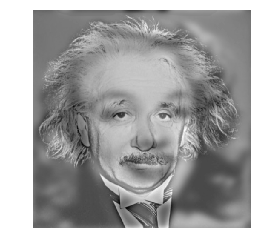

In [28]:
marilyn = readImg("marilyn.png") #ndimage.imread
einstein = readImg("albert.png" )

#showImg(einstein)
# showImg(marilyn)
# showImg(einstein)

hybrid = hybridImage(einstein, marilyn, 11, 11, 1, True)
showImg(hybrid.real)


In [29]:
# print('numpy:')
# %timeit hybridImage(einstein, marilyn, 11, 33, 2, True)
# print('my fft:')
# %timeit hybridImage(einstein, marilyn, 11, 33, 2, False)
print('''numpy:
620 ms ± 16.9 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
my fft:
4 s ± 39.2 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)''')

numpy:
620 ms ± 16.9 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
my fft:
4 s ± 39.2 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [86]:
from PIL import Image

img = Image.open('albert.png').convert("L") #Image.new('RGB', (100, 100), 'red')
# params for img1:
a = 1
b = 0
c = 0 #left/right (i.e. 5/-5)
d = 0
e = 1
f = 0 #up/down (i.e. 5/-5)
# params for img 2:
a2 = 1
b2 = 0
c2 = 0 #left/right (i.e. 5/-5)
d2 = 0
e2 = 1
f2 = 0 #up/down (i.e. 5/-5)

Button(description='Click Me!', style=ButtonStyle())

c2 is 340


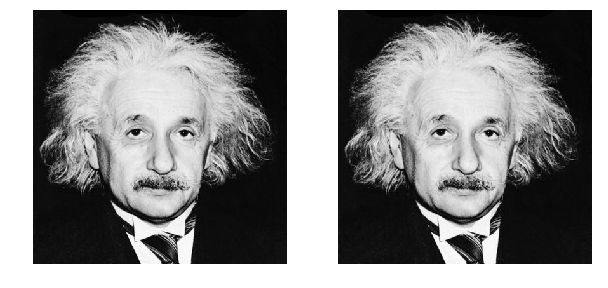

In [87]:
from ipywidgets import interact, interactive, fixed, interact_manual, HBox, VBox
import ipywidgets as widgets
from IPython.display import display, clear_output

button = widgets.Button(description="Click Me!")
display(button)

def on_button_clicked(btn=None):
    clear_output()
    display(button)
    
    i1a = widgets.IntSlider(min=-img.size[0],max=img.size[0],step=10,value=c, description="left-right")
    i2a = widgets.IntSlider(min=-100,max=100,step=10,value=f, description="up-down")
    i3a = widgets.FloatSlider(min=0.1,max=2,step=0.1,value=a, description="h stretch")
    i4a = widgets.FloatSlider(min=0.1,max=2,step=0.1,value=e, description="v stretch")
    
    print('c2 is',c2)
    i1b = widgets.IntSlider(min=-img.size[0],max=img.size[0],step=10,value=c2, description="left-right")
    i2b = widgets.IntSlider(min=-100,max=100,step=10,value=f2, description="up-down")
    i3b = widgets.FloatSlider(min=0.1,max=2,step=0.1,value=a2, description="h stretch")
    i4b = widgets.FloatSlider(min=0.1,max=2,step=0.1,value=e2, description="v stretch")
    
    i1a.observe(left_right, names='value')
    i2a.observe(up_down, names='value')
    i3a.observe(width_stretch, names='value')
    i4a.observe(height_stretch, names='value')
    
    i1b.observe(left_right2, names='value')
    i2b.observe(up_down2, names='value')
    i3b.observe(width_stretch2, names='value')
    i4b.observe(height_stretch2, names='value')
    display(HBox([i1a,i1b]))
    display(HBox([i2a,i2b]))
    display(HBox([i3a,i3b]))
    display(HBox([i4a,i4b]))


    img2 = img.transform(img.size, Image.AFFINE, (a, b, c, d, e, f))
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10,10))
    
    axes[0].axis('off')
    axes[0].imshow(img2)
    axes[1].axis('off')
    axes[1].imshow(img2)
    plt.show()
    
def left_right(x):
    global c2
    c2 = x['new']
def up_down(x):
    global f2
    f2 = x['new']
def width_stretch(x):
    global a2
    a2 = x['new']
def height_stretch(x):
    global e2
    e2 = x['new']
def left_right2(x):
    global c2
    c2 = x['new']
def up_down2(x):
    global f2
    f2 = x['new']
def width_stretch2(x):
    global a2
    a2 = x['new']
def height_stretch2(x):
    global e2
    e2 = x['new'] 
def fa(x):
    a = x
#     hybrid = hybridImage(einstein, marilyn, 20, 20, t)
#     showImg(hybrid.real)

# interact(left_right, x=widgets.IntSlider(min=-100,max=100,step=10,value=c, description="high/low"))
button.on_click(on_button_clicked)


In [ ]:
img.size
